<a href="https://colab.research.google.com/github/slucey-cs-cmu-edu/RVSS24/blob/main/ConvMixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvMixer Study

This notebook showcases the ConvMixer Baseline which provides a useful framework to connect concepts from classical CNNs with modern ViTs.

## Section 0: Import Functions & Dataloader

---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import  pyplot as plt

import os
import time
import argparse

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

parser = argparse.ArgumentParser()
args = parser.parse_args('')
print(args)

Namespace()


Preparing dataset

In [ ]:
#@markdown Choose dataset from `CIFAR-10`, `CIFAR-100`, `SVHN`, or edit the code to add your own dataset.
args.dataset = "cifar10" # @param ["cifar10", "cifar100", "svhn"]
#@markdown Chooose whether use data augmentation or not. You can edit the code to add your own data augmentation.
args.data_aug = True #@param{type:'boolean'}
#@markdown Other parameters, you can change as you need.
args.data_path = "./data" # @param{type:'string'}
args.batch_size = 256 # @param{type:'integer'}
args.num_workers = 2 # @param{type:'integer'}
args.pin_memory = False #@param{type:'boolean'}

print(f'==> Preparing {args.dataset} data..')
# Get imagne size, dataset mean & std.
# Image size and patch size will also be used in future model claim.
if args.dataset[:5] == 'cifar':
    args.image_size = 32
    args.patch_size = 2
    dataset_mean = (0.4914, 0.4822, 0.4465)
    dataset_std = (0.2471, 0.2435, 0.2616)
elif args.dataset == 'svhn':
    args.image_size = 32
    args.patch_size = 2
    dataset_mean = (0.4376821, 0.4437697, 0.47280442)
    dataset_std = (0.19803012, 0.20101562, 0.19703614)
else:
    print('no available dataset')
# Set data augmentation for train set.
if args.data_aug:
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(args.image_size,scale=(1.0,1.0),ratio=(1.0,1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandAugment(2, 12),
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
    ])
else:
    train_transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
    ])
test_transform = transforms.Compose([
    transforms.Resize(args.image_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std)
])
# Get train and test dataset.
# Need to specify number of classes for futrue model claim.
if args.dataset == 'cifar10':
    args.num_classes = 10
    train_dataset = torchvision.datasets.CIFAR10(root=args.data_path, train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10(root=args.data_path, train=False, download=True, transform=test_transform)
elif args.dataset == 'cifar100':
    args.num_classes = 100
    train_dataset = torchvision.datasets.CIFAR100(root=args.data_path, train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR100(root=args.data_path, train=False, download=True, transform=test_transform)
elif args.dataset == 'svhn':
    args.num_classes = 10
    train_dataset = torchvision.datasets.SVHN(root=args.data_path, split='train', download=True, transform=train_transform)
    test_dataset = torchvision.datasets.SVHN(root=args.data_path, split='test', download=True, transform=test_transform)
else:
    print('no available dataset')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=args.pin_memory)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=args.pin_memory)

==> Preparing cifar10 data..


100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Section 1: ConvMixer Baseline

---



ConvMixer is a Convolution based architecture inspired by [Vision Transformers (ViT)](https://arxiv.org/pdf/2010.11929.pdf) and [MLP-Mixer](https://arxiv.org/pdf/2105.01601.pdf). This secttion is based on the [official inplementation](https://github.com/locuslab/convmixer-cifar10/tree/main) of ConvMixer.

![ConvMixer and Simple ViT](https://drive.google.com/uc?export=view&id=1d5qKft2-t8LaZlyRjfqg4Jrsul5Or1U7)

### code
Since the architecture of ConvMixer is simple, the code is pretty short.

In [ ]:
# from: https://github.com/locuslab/convmixer-cifar10/blob/main/train.py

import torch
from torch import nn

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


def ConvMixer(dim, depth, kernel_size=5, patch_size=2, n_classes=10):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

### Model & training settings

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 0.05 # @param
args.num_epochs = 25 # @param{type:'integer'}

model = ConvMixer(dim = 256, depth = 8, kernel_size=5, patch_size=2)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

lr_schedule = lambda t: np.interp([t], [0, args.num_epochs*2//5, args.num_epochs*4//5, args.num_epochs],
                                  [0, args.lr, args.lr/20.0, 0])[0]
optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=0.005)
print(args)

scaler = torch.cuda.amp.GradScaler()
train_losses = []
train_acces = []
test_acces = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(train_dataloader))
        optimizer.param_groups[0].update(lr=lr)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces.append(test_acc)
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

cuda
using data parallel
Namespace(dataset='cifar10', data_aug=True, data_path='./data', batch_size=256, num_workers=2, pin_memory=False, image_size=32, patch_size=2, num_classes=10, lr=0.05, num_epochs=25)


<ipython-input-4-2c26cf7749da>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-4-2c26cf7749da>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-4-2c26cf7749da>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


epoch:  0, train_loss: 1.5800, train_acc: 0.4219, val_acc: 0.5759, lr: 5.000E-03, epoch_time: 48.6
epoch:  1, train_loss: 1.0506, train_acc: 0.6279, val_acc: 0.6618, lr: 1.000E-02, epoch_time: 44.2
epoch:  2, train_loss: 0.8642, train_acc: 0.6988, val_acc: 0.7490, lr: 1.500E-02, epoch_time: 45.2
epoch:  3, train_loss: 0.7769, train_acc: 0.7292, val_acc: 0.7612, lr: 2.000E-02, epoch_time: 45.2
epoch:  4, train_loss: 0.7122, train_acc: 0.7549, val_acc: 0.7579, lr: 2.500E-02, epoch_time: 44.1


KeyboardInterrupt: 

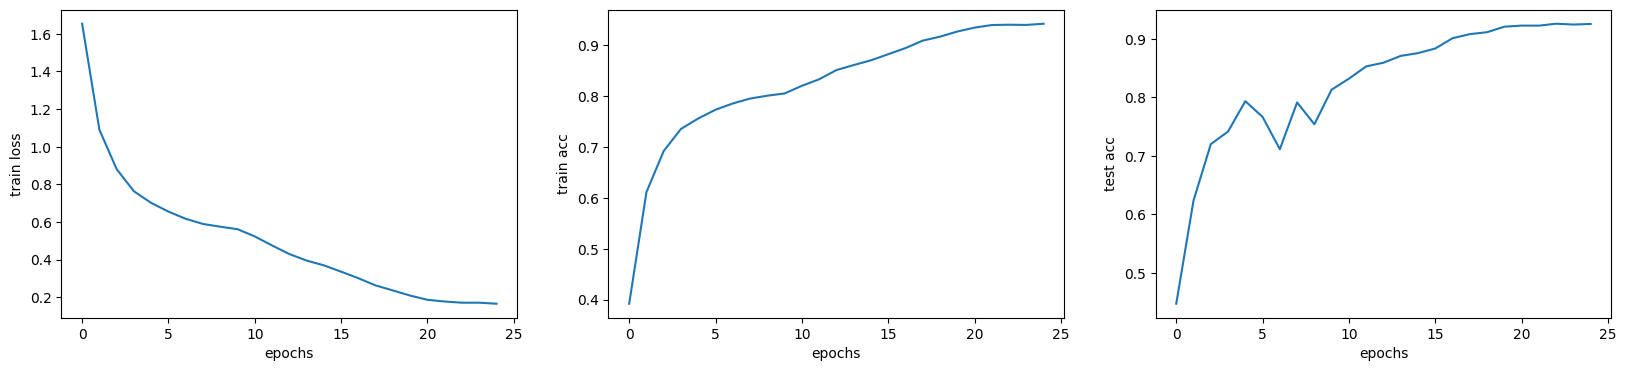

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()